In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

In [2]:
dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(50)
LABELS_INDEX = 50
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7

In [3]:
spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
2708,-0.023177,-0.034199,-0.071174,0.034209,-0.055537,0.050054,0.085029,-0.002683,-0.022024,0.001740,...,-0.000197,-0.003055,0.006381,-0.000235,-0.005397,-0.003612,-0.000170,-0.004931,0.000354,0
2709,-0.068698,0.057827,0.062494,-0.120875,-0.031199,-0.126144,-0.001503,-0.027971,0.042212,-0.037903,...,0.007117,-0.001194,-0.000628,-0.002963,0.001091,0.002984,0.002117,-0.000214,-0.001545,0
2710,-0.022014,-0.018537,-0.052204,-0.010769,-0.049487,0.042335,0.060547,-0.026063,-0.004448,-0.008374,...,-0.015350,-0.018111,0.004594,0.017790,-0.003928,0.013328,0.001513,0.000267,0.002323,0
2711,-0.027492,-0.037501,-0.001082,-0.047973,-0.013806,-0.009351,-0.009311,-0.024605,-0.013044,0.041648,...,0.009767,0.000280,0.005480,-0.005193,-0.005427,-0.004483,-0.003516,-0.003058,0.003073,0
2712,-0.053112,0.017851,-0.001592,-0.010851,-0.040524,-0.143514,0.026496,-0.028555,0.030408,0.003770,...,-0.005770,0.001425,-0.000558,-0.001323,-0.000568,0.003484,-0.000813,-0.002720,0.002752,0


In [4]:
rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

2621 1311 438 4370 4370


In [5]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [6]:
learn_dataloader = DataLoader(learn_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)



In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(50, 20)
        self.lin2 = nn.Linear(20, 10)
        self.lin3 = nn.Linear(10, 10)
        self.lin4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.sigmoid(self.lin3(x))
        x = F.sigmoid(self.lin4(x))
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=50, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=10, bias=True)
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('rprop/net_params.pkl'))

In [9]:
#Инициализация весов
STD = [(2/(50+20+1))**(1/2), (2/(20+10+1))**(1/2), (32/(10+10+1))**(1/2), (32/(10+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([20, 50])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])
tensor([ 0.1579,  0.1707, -0.1184,  0.1552,  0.1477,  0.0334, -0.0875,
         0.2713,  0.0039,  0.0062, -0.1087,  0.4171,  0.0576, -0.1161,
         0.0923, -0.1069,  0.0521,  0.0848, -0.1396, -0.1449])


In [10]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([ 0.1579,  0.1707, -0.1184,  0.1552,  0.1477,  0.0334, -0.0875,
         0.2713,  0.0039,  0.0062, -0.1087,  0.4171,  0.0576, -0.1161,
         0.0923, -0.1069,  0.0521,  0.0848, -0.1396, -0.1449])

In [11]:
for i in net.parameters():
    print(i.shape)

torch.Size([20, 50])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])


In [12]:
criterion = nn.BCELoss(size_average=True)

In [13]:
def get_delta(state_value):
    return state_value['step_size']

In [14]:
%%time

optimizer =  optim.Rprop(net.parameters(), lr=0.001)
state = optimizer.state

tmp_null_weigth = list(null_weigth)
net.apply(init_weigths)

learn_epoch_loss = []
valid_epoch_loss = []
test_epoch_loss = []
epoch_list = []

delta_l1 = []
delta_l2 = []
delta_l3 = []
delta_l4 = []

delta_mean = []
delta_min = []
delta_max = []

for epoch in range(5*10**4):
    loss_acc = []
    min_acc = 1000
    max_acc = -1000
    mean_acc = 0

    for learn_data in learn_dataloader:
        optimizer.zero_grad()
        features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
        features.requres_grad = True
        labels.requres_grad = True
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_acc.append(float(loss.data))
    learn_epoch_loss.append(np.mean(loss_acc))

    #критерий останова
    if (epoch > 5) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('breaked on epoch: ', epoch, '\n')
            break

    if epoch % 1000 == 0:
        epoch_list.append(epoch)
        for valid_data in valid_dataloader:
            features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
            outputs = net(features)
            loss = criterion(outputs, labels)
            valid_epoch_loss.append(float(loss.data))

        for test_data in test_dataloader:
            features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
            outputs = net(features)
            loss = criterion(outputs, labels)
            test_epoch_loss.append(float(loss.data))

        state_values = list(state.values())
        for k in range(len(state_values)):
            g_matrix = get_delta(state_values[k]).clone()
            mean_acc += float(torch.mean(g_matrix))
            max_acc = max(max_acc, float(torch.max(g_matrix)))
            min_acc = min(min_acc, float(torch.min(g_matrix)))
        delta_max.append(max_acc)
        delta_mean.append(mean_acc/len(state_values))
        delta_min.append(min_acc)

        g_matrix = get_delta(state_values[0]).clone()
        delta_l1.append(float(g_matrix[10, 30]))

        g_matrix = get_delta(state_values[2]).clone()
        delta_l2.append(float(g_matrix[9, 0]))

        g_matrix = get_delta(state_values[4]).clone()
        delta_l3.append(float(g_matrix[5, 5]))

        g_matrix = get_delta(state_values[6]).clone()
        delta_l4.append(float(g_matrix[0, 3]))

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1311])) that is different to the input size (torch.Size([1311, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.p

4.470348358154297e-08
breaked on epoch:  7506 

CPU times: user 9min 7s, sys: 5.41 s, total: 9min 13s
Wall time: 9min 14s


In [15]:
torch.save(net.state_dict(), 'rprop/net_params.pkl')

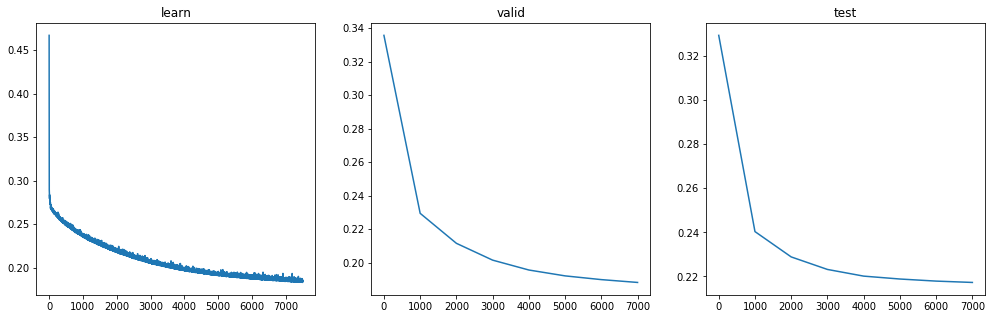

In [22]:
plt.figure(figsize=(17,5))
plt.subplot(1, 3, 1)
plt.plot(learn_epoch_loss)
plt.title('learn')

plt.subplot(1, 3, 2)
plt.plot(epoch_list, valid_epoch_loss)
plt.title('valid')


plt.subplot(1, 3, 3)
plt.plot(epoch_list, test_epoch_loss)
plt.title('test')


plt.savefig('rprop/losss.png', bbox_inches='tight')

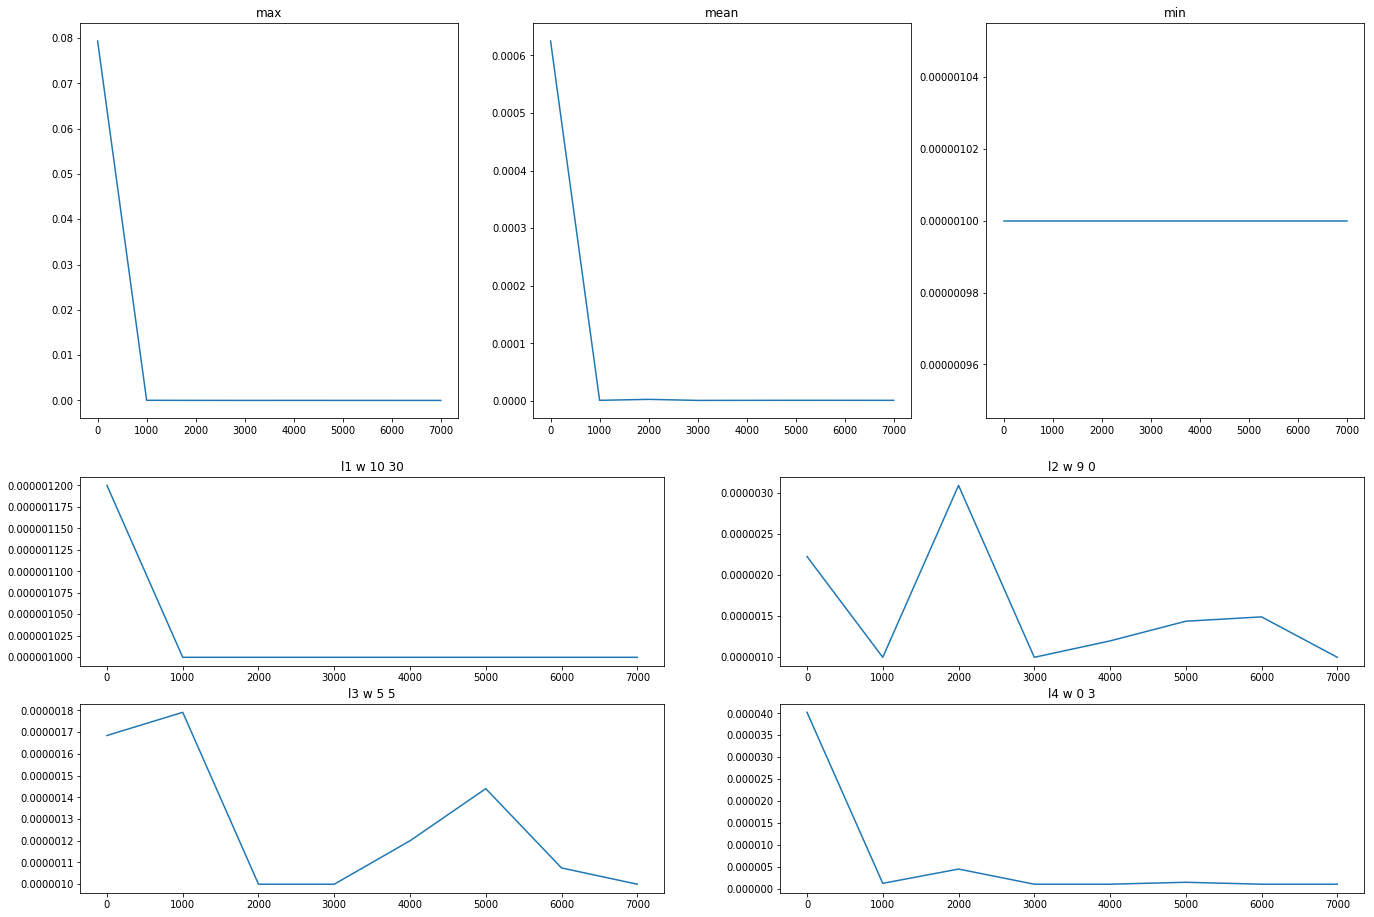

In [23]:
plt.figure(figsize=(23,16))
plt.subplot(4, 2, 5)
plt.plot(epoch_list, delta_l1)
plt.title('l1 w 10 30')

plt.subplot(4, 2, 6)
plt.plot(epoch_list, delta_l2)
plt.title('l2 w 9 0')

plt.subplot(4, 2, 7)
plt.plot(epoch_list, delta_l3)
plt.title('l3 w 5 5')

plt.subplot(4, 2, 8)
plt.plot(epoch_list, delta_l4)
plt.title('l4 w 0 3')

plt.subplot(2, 3, 1)
plt.plot(epoch_list, delta_max)
plt.title('max')

plt.subplot(2, 3, 2)
plt.plot(epoch_list, delta_mean)
plt.title('mean')

plt.subplot(2, 3, 3)
plt.plot(epoch_list, delta_min)
plt.title('min')

plt.savefig('rprop/lrs.png', bbox_inches='tight')